In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pmdarima as pm  # Auto ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # SES
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # State space model ETS
from fbprophet import Prophet  # Prophet

In [2]:
# 读入数据
df = pd.read_csv('class1.csv')
# 查看全部数据
# print(df)
# 查看前十条数据
print(df.head(10))

           ds       y
0  2014-01-01  448.41
1  2014-02-01  159.52
2  2014-03-01  192.40
3  2014-04-01  186.26
4  2014-05-01  208.95
5  2014-06-01  262.02
6  2014-07-01  192.00
7  2014-08-01     NaN
8  2014-09-01  268.85
9  2014-10-01  194.43


In [3]:
# 填充缺失值
df = df.fillna(df.bfill())
print(df.head(10))

           ds       y
0  2014-01-01  448.41
1  2014-02-01  159.52
2  2014-03-01  192.40
3  2014-04-01  186.26
4  2014-05-01  208.95
5  2014-06-01  262.02
6  2014-07-01  192.00
7  2014-08-01  268.85
8  2014-09-01  268.85
9  2014-10-01  194.43


In [4]:
row_num = df.shape[0]  # 总共有多少行数据
Pre_num = 5  # 将最后五行作为测试集

# 划分训练集和测试集
# 训练集
data_train = df.iloc[:-Pre_num]
print(data_train.head(5))
data_tr_y = data_train['y']
# 测试集
data_test = df.iloc[-Pre_num:]
print(data_test.head(5))
data_test = data_test['y']
# 验证集
data_pre = df.iloc[:-1]
data_pre_y = data_pre['y']

           ds       y
0  2014-01-01  448.41
1  2014-02-01  159.52
2  2014-03-01  192.40
3  2014-04-01  186.26
4  2014-05-01  208.95
            ds         y
55  2018-08-01  280.8920
56  2018-09-01  344.6200
57  2018-10-01  275.0008
58  2018-11-01  264.4712
59  2018-12-01  182.8200


In [5]:
def prophet(data, Pre_day):
    # 添加假日数据：
    NewYear = pd.DataFrame({  # 元旦
        'holiday': 'NewYear',
        'ds': pd.to_datetime(['2014-01-01','2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']),
        'lower_window': -2,
        'upper_window': 2,
    })
    SpringFestival = pd.DataFrame({  # 春节
        'holiday': 'SpringFestival',
        'ds': pd.to_datetime(['2014-01-31','2015-02-19', '2016-02-08', '2017-01-28', '2018-02-16']),
        'lower_window': -2,
        'upper_window': 4,
    })
    LaborDay = pd.DataFrame({  # 劳动节
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['2014-05-01', '2015-05-01', '2016-05-01', '2017-05-01', '2018-05-01']),
        'lower_window': -2,
        'upper_window': 2,
    })
    NationalDay = pd.DataFrame({  # 国庆节
        'holiday': 'NationalDay',
        'ds': pd.to_datetime(['2014-10-01', '2015-10-01', '2016-10-01', '2017-10-01', '2018-10-01']),
        'lower_window': -1,
        'upper_window': 3,
    })
    holidays = pd.concat((NewYear, SpringFestival, LaborDay, NationalDay))  # 结合为节假日因子
    
    m = Prophet(holidays=holidays)
    m.fit(data)
    future = m.make_future_dataframe(periods=Pre_day)
    forecast = m.predict(future)
    
    # print("======================prophet========================")
    # print(forecast.head(5))
    
    register_matplotlib_converters()
    fig1 = m.plot(forecast)
    fig1.show()
    
    result = forecast['yhat']
    result = result.iloc[-Pre_day:]
    # print(result)
    return result

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


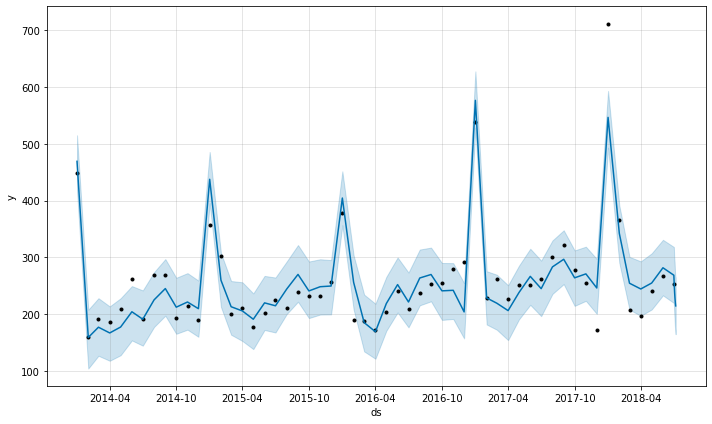

In [6]:
# Prophet
P_prophet = prophet(data_train, Pre_num)

In [7]:
def autoarima(data, Pre_day):
    stepwise_fit = pm.auto_arima(data, m=12, seasonal=True, error_action='ignore', suppress_warnings=True,
                                 stepwise=True)
    # print("======================autoarima========================")
    result =stepwise_fit.predict(n_periods=Pre_day)
    # result = stepwise_fit.predict(n_periods=data.shape[0])
    # 绘图
    x = np.arange(data.shape[0])
    plt.scatter(x, data, marker='x')
    plt.plot(x, stepwise_fit.predict(n_periods=data.shape[0]))
    plt.title('Actual test samples vs. auto_arima forecasts')
    plt.show()
    
    return result

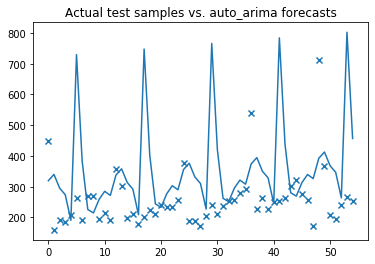

In [15]:
# auto_arima
P_auar = autoarima(data_tr_y, Pre_num)

In [9]:
def SES(data, Pre_day):
    model = SimpleExpSmoothing(data)
    model_fit = model.fit()
    yhat = model_fit.predict(row_num - Pre_day, row_num -1)
    # yhat = model_fit.predict(0, row_num - Pre_day-1)
    # print("======================SES========================")
    
    # 绘图
    x = np.arange(data.shape[0])
    plt.scatter(x, data, marker='x')
    plt.plot(x, model_fit.predict(0, row_num - Pre_day-1))
    plt.title('Actual test samples vs. SES forecasts')
    plt.show()
    
    result = yhat
    return result

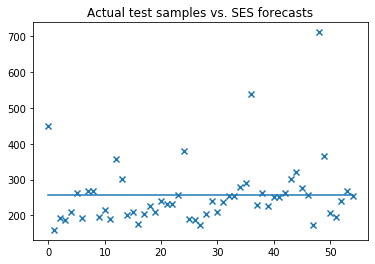

In [10]:
# SES
P_SES = SES(data_tr_y, Pre_num)

In [11]:
def ETS(data, Pre_day):
    # fit model
    # model = ExponentialSmoothing(data)
    model = ExponentialSmoothing(data, trend='add', seasonal='add',  seasonal_periods=12)
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(row_num - Pre_day, row_num -1)
    # yhat = model_fit.predict(0, row_num - Pre_day - 1)
    # print("======================ETS========================")
    
    # 绘图
    x = np.arange(data.shape[0])
    plt.scatter(x, data, marker='x')
    plt.plot(x, model_fit.predict(0, row_num - Pre_day - 1))
    plt.title('Actual test samples vs. ETS forecasts')
    plt.show()

    result = yhat
    return result

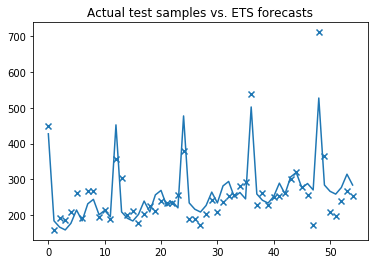

In [12]:
# ETS
P_ETS = ETS(data_tr_y, Pre_num)

In [13]:
# 计算误差
def cal_err(data_real, data_pre):
    error = 0
    for i in range(0, Pre_num):
        error += (data_pre.loc[row_num -Pre_num + i] - data_real.loc[row_num -Pre_num + i]) ** 2
    error /= Pre_num
    error = np.sqrt(error).astype(float)
    return error


def cal_err2(data_real, data_pre):
    error = 0
    for i in range(0, Pre_num):
        error += (data_pre[i] - data_real.loc[row_num -Pre_num + i]) ** 2
    error /= Pre_num
    error = np.sqrt(error).astype(float)
    return error

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: view limit minimum -36852.71611745968 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

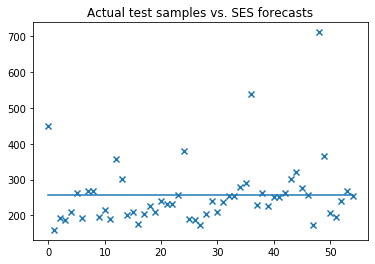

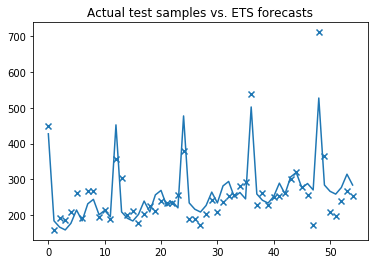

In [18]:
# Prophet
P_prophet = prophet(data_train, Pre_num)
err_pro = cal_err(data_test, P_prophet)

# auto_arima
P_auar = autoarima(data_tr_y, Pre_num)
err_auar = cal_err2(data_test, P_auar)

# SES
P_SES = SES(data_tr_y, Pre_num)
err_SES = cal_err(data_test, P_SES)

# ETS
P_ETS = ETS(data_tr_y, Pre_num);
err_ETS = cal_err(data_test, P_ETS)

In [19]:
print(err_pro)
print(err_auar)
print(err_SES)
print(err_ETS)

57.99407298729579
20.49400749688166
53.186537458864706
60.575978810319214


In [21]:
# 计算权重
weight = [0, 0, 0, 0]
max_err = max(err_pro, err_auar, err_SES, err_ETS)
error_all = [(max_err /err_pro) ** 2, (max_err / err_auar) ** 2, (max_err / err_SES) ** 2, (max_err / err_ETS) ** 2]
# 计算总误差
Total_error = error_all[0] + error_all[1] + error_all[2] + error_all[3]
# 基于总误差计算权重
for i in range(0, 4):
    weight[i] = error_all[i] / Total_error
    
print("err_pro, err_auar, err_SES, err_ETS")
print(error_all)
print(weight)

err_pro, err_auar, err_SES, err_ETS
[1.0910223795801721, 8.736693483101396, 1.2971716395197774, 1.0]
[0.08998206205064505, 0.7205587253090139, 0.10698422061930621, 0.08247499202103475]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: view limit minimum -36859.35703889701 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

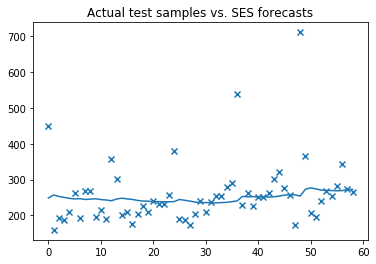

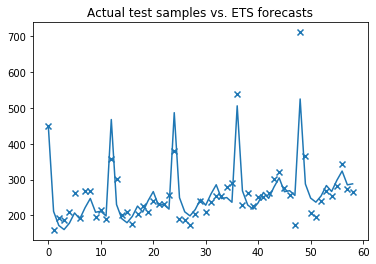

In [22]:
# 預測結果
Pre_value = 0

pro_pre = prophet(data_pre, 1);
Pre_value += weight[0] * pro_pre

aa_pre = autoarima(data_pre_y, 1);
Pre_value += weight[1] * aa_pre

ses_pre = SES(data_pre_y, 1);
Pre_value += weight[2] * ses_pre

ets_pre = ETS(data_pre_y, 1);
Pre_value += weight[3] * ets_pre

In [23]:
print("pro_pre: ", pro_pre)
print("aa_pre: ", aa_pre)
print("ses_pre: ", ses_pre)
print("ets_pre: ", ets_pre)
print("Pre_value: ", Pre_value)

pro_pre:  59    258.349554
Name: yhat, dtype: float64
aa_pre:  [189.56676596]
ses_pre:  59    272.157928
dtype: float64
ets_pre:  59    274.965915
dtype: float64
Pre_value:  59    211.635228
Name: yhat, dtype: float64
